# Requirements

In [ ]:
%pip install tensorflow numpy opencv-python firebase_admin

# Imports

In [54]:
# Importing necessary modules
import tensorflow as tf
import numpy as np
import cv2
import os
import urllib

import firebase_admin
from firebase_admin import firestore
from firebase_admin import credentials

# Connect with Firestore

In [40]:
CRED = "path/to/credentials"

In [ ]:
cred = credentials.Certificate(CRED)
firebase_admin.initialize_app(cred)

In [47]:
db = firestore.client()

# Getting & Preprocessing Images

In [62]:
# For the collection Markers
markers = db.collection("Markers").get()
markerImages = []

# For the collection SOS_Reports
sos = db.collection("SOS_Reports").get()
sosImages = []

In [63]:
# For creating markerImages
for obj in markers:
    data = obj.to_dict()
    req = urllib.request.urlopen(data["imageUrl"])
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, -1)
    img_resized = cv2.resize(img, (320, 320))
    input_data = np.expand_dims(img_resized, axis=0).astype(np.uint8)
    markerImages.append([data["id"], input_data])

# For creating sosImages
# for obj in sos:
#     data = obj.to_dict()
#     req = urllib.request.urlopen(data["incidentImageLink"])
#     arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
#     img = cv2.imdecode(arr, -1)
#     markerImages.append([data["id"], img])

# Loading Model

In [72]:
# Setting up Efficientdet model class
class human_detection:

    def __init__(self):
        self.interpreter = tf.lite.Interpreter(model_path="/content/gdrive/MyDrive/hestia_human_detection/1.tflite")
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.image_verification = {0: [], 1: []}

    def forward(self, THRESHOLD_SCORE, IMAGE_ARRAY):
        for (image_id, img) in IMAGE_ARRAY:
            detection = False

            self.interpreter.set_tensor(self.input_details[0]['index'], img)
            self.interpreter.invoke()

            classes = self.interpreter.get_tensor(self.output_details[1]['index'])[0]
            scores = self.interpreter.get_tensor(self.output_details[2]['index'])[0]

            for i in range(len(scores)):
                if ((scores[i] > THRESHOLD_SCORE) and (scores[i] <= 1.0)):
                    if int(classes[i]) == 0:
                        detection = True
                        break
            if detection:
                self.image_verification[1].append(image_id)
            else:
                self.image_verification[0].append(image_id)

    def get_dict(self):
        return self.image_verification

In [73]:
# Initializing Model
model = human_detection()

In [74]:
# Execute model
model.forward(0.2, markerImages)

In [ ]:
# Get model results
model.get_dict()

# Testing model on single images

## Loading Pre-trained Efficientdet

In [ ]:
# Creating a TensorFlow Lite Interpreter instance to load a pre-trained model (https://www.kaggle.com/models/tensorflow/efficientdet)
interpreter = tf.lite.Interpreter(model_path="/content/gdrive/MyDrive/hestia_human_detection/1.tflite")

# Allocating tensors for the interpreter to prepare for inference
interpreter.allocate_tensors()

## Loading and Preprocessing image(s)

In [ ]:
# Reading an image using OpenCV from the specified path
img = cv2.imread("/content/gdrive/MyDrive/hestia_human_detection/94921710.jpeg", cv2.IMREAD_UNCHANGED)

imH, imW, _ = img.shape

[[[ 58  99 101]
  [102 139 147]
  [ 24  67  82]
  ...
  [160 191 212]
  [ 94 125 146]
  [154 185 206]]

 [[ 44  82  84]
  [105 141 149]
  [ 42  81  96]
  ...
  [162 193 214]
  [ 96 127 148]
  [154 185 206]]

 [[109 139 144]
  [110 139 148]
  [ 64  99 113]
  ...
  [159 190 211]
  [ 97 128 149]
  [156 187 208]]

 ...

 [[173 198 224]
  [176 201 227]
  [182 207 233]
  ...
  [163 204 227]
  [134 175 198]
  [135 176 199]]

 [[202 231 255]
  [194 223 250]
  [194 223 250]
  ...
  [118 162 186]
  [144 190 214]
  [107 153 177]]

 [[179 209 236]
  [192 222 249]
  [186 216 243]
  ...
  [162 206 237]
  [188 221 247]
  [182 205 231]]]


In [ ]:
# Resizing the image using OpenCV to the required input dimensions
img_resized = cv2.resize(img, (imH, imW))

# Expanding the dimensions of the resized image
input_data = tf.expand_dims(img_resized, axis=0)

## Inference

In [ ]:
# Getting details about the input tensor(s) and the output tensor(s) of the TensorFlow Lite model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Getting the shape of the input tensor
input_shape = input_details[0]['shape']

# Setting the input tensor of the TensorFlow Lite model with the resized image data
interpreter.set_tensor(input_details[0]['index'], input_data)

# Invoking the TensorFlow Lite interpreter to perform inference
interpreter.invoke()

In [ ]:
# Getting bounding box information, class labels, and confidence scores from the output tensor
boxes = interpreter.get_tensor(output_details[0]['index'])[0]
classes = interpreter.get_tensor(output_details[1]['index'])[0]
scores = interpreter.get_tensor(output_details[2]['index'])[0]

# Creating an empty list to store detection results
detections = []

In [ ]:
# Threshold score for filtering detections
THRESHOLD_SCORE = 0.2

## Post-processing and Visualization

In [ ]:
# Post-processing the detection results and visualizing them on the image
for i in range(len(scores)):

   # Filtering detections based on confidence scores
  if ((scores[i] > THRESHOLD_SCORE) and (scores[i] <= 1.0)):
    ymin = int(max(1,(boxes[i][0] * imH)))
    xmin = int(max(1,(boxes[i][1] * imW)))
    ymax = int(min(imH,(boxes[i][2] * imH)))
    xmax = int(min(imW,(boxes[i][3] * imW)))

    # Setting the object name only if the class is a "Person"
    object_name = "Person" if int(classes[i]) == 0 else ""

    # Drawing bounding box on the image only for label "Person"
    if object_name == "Person":
      cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (10, 255, 0), 2)

      # Adding label with object name and confidence score
      label = '%s: %d%%' % (object_name, int(scores[i]*100))
      labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
      label_ymin = max(ymin, labelSize[1] + 10)

      # Drawing filled rectangle as background for label
      cv2.rectangle(img, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED)

      # Adding text label to the image
      cv2.putText(img, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

      # Appending detection results to the list
      detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])


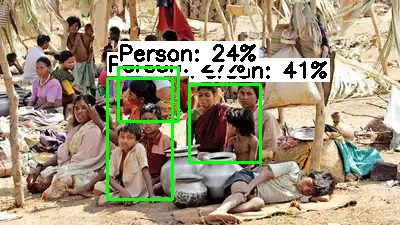

In [ ]:
# Displaying the image using cv2_imshow in the Colab environment
cv2_imshow(img)